# Image segmentation (with U-Nets)


In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from os import listdir
import skimage
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.misc as m
from torch.optim.lr_scheduler import StepLR

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## U-Net Architecture
![architecture](.\architecture.png "UNet architecture")

### Contracting Path
It consits of 4 blocks and every block has the same architecture (typical architecture of a concolutional network)
1. Two 3x3 unpadded convolutions each followed by a rectified linear unit
    - because its is unpadded we loss with every convolution 2 pixels in each dimension
2. 2x2 max pooling operations with stride 2
    - with this setting the image get downsampled by a factor of 2

They start with 64 feature channels (filters) at the first block and with each block they double the number of feature channels

The output of the last block will be sended through two convoltuion layers (3x3) each followed by a ReLU, because of the doubling of the feature channels the resulting feature map for each layer is 1024 dimensional.

### Expansive Path
Its symetric to the contracting path, so again 4 blocks. However the architecture changes slightly
1. Upsampling by a 2x2 up-convolution (that halves the number of feature channels)
2. Copy a cropped version of the feature map from the corresponding feature map of the contracting path and concatenate with the upsampled feature map
    - The cropping is necessary due to the loss of border pixels in every convolution
3. Two 3x3 unpadded convolutions each followed by a rectified linear unit

At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes (in our case 2 classes). 

In total the network has 23 convolutional layers. (2\*4 (Contracting Path) + 2 (last layer) + 3\*4 (Expansive Path) + 1 (final layer))

In [0]:
# because 18 of the 23 convolutional layers uses the same setting, we defined a own function for this
def conv3x3(_input, output):
    return nn.Conv2d(_input, output, 3, padding=1)

def conv_upsample(in_channels,channels,i):
    # a = (i+2p-k)mod s
    s = 2
    k = 2
    p = 0
    a = np.mod(i+2*p-k,s)
    return nn.ConvTranspose2d(in_channels=in_channels, out_channels=channels, kernel_size=k, stride=s, output_padding=a)


# define block of contracting path
class ContractingBlock(nn.Module):
    def __init__(self,in_channels,channels):
        super(ContractingBlock, self).__init__()
        # for the first conv layer the number of input channels are the number of channels from the previous block and they will be doubled (first block starts with 64) 
        self.conv1 = conv3x3(in_channels,channels)
        self.conv2 = conv3x3(channels,channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample_block = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x, isInitBlock = 0):
        if not isInitBlock:
            x = self.downsample_block(x)
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        #print(x.size())
        
        return x

# define block of expansive path
class ExpansiveBlock(nn.Module):
    def __init__(self, in_channels, channels,target_size):
        super(ExpansiveBlock, self).__init__()
        self.upsampled = conv_upsample(in_channels, channels,target_size)
        self.conv1 = conv3x3(in_channels,channels)
        self.conv2 = conv3x3(channels,channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x, cop):
        x = self.upsampled(x)
        #n, c, h, w = x.size()
        #cop = cop[0:n,0:c,0:h,0:w]
        x = torch.cat([cop, x], dim=1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        #print(x.size())
        
        return x


In [0]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.contracted1 = ContractingBlock(3,64)
        self.contracted2 = ContractingBlock(64,128)
        self.contracted3 = ContractingBlock(128,256)
        self.contracted4 = ContractingBlock(256,512)
        self.bottom = ContractingBlock(512,1024)
        self.expanded1 = ExpansiveBlock(1024,512,73)
        self.expanded2 = ExpansiveBlock(512,256,146)
        self.expanded3 = ExpansiveBlock(256,128,292)
        self.expanded4 = ExpansiveBlock(128,64,584)
        self.final = nn.Conv2d(64, 2, 1, padding=0)
        
    def forward(self,x):
        con1 = self.contracted1(x, 1)
        con2 = self.contracted2(con1)
        con3 = self.contracted3(con2)
        con4 = self.contracted4(con3)
        bot = self.bottom(con4)
        exp1 = self.expanded1(bot,con4)
        exp2 = self.expanded2(exp1,con3)
        exp3 = self.expanded3(exp2,con2)
        exp4 = self.expanded4(exp3,con1)
        fin = self.final(exp4)
        
        return fin



## Weight Initialization

In [0]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        o,i,h,w = m.weight.size()
        N = i*h*w
        std = np.sqrt(2/N)
        #print(m.weight.data[1][1])
        m.weight.data.normal_(0.0, std)
        #print(m.weight.data[1][1])
        #print(N)
        #print(std)     

## Loss-Function
For the loss a pixel-wise soft-max over the final feature map combined with the corss entropy loss function is computed.
The function torch.nn.functional.corss_entropy() does exactly this.

In [0]:
def EngergyFunction(featuremap, target):
    featuremap = featuremap.transpose(1, 2).transpose(2, 3).contiguous().view(-1, 2)
    target = target/255
    #target = target+1
    target = target.contiguous().view(-1)
    loss = F.cross_entropy(featuremap, target,weight = torch.tensor([1., 3.]).to(device),  reduction='elementwise_mean') #, weight = torch.tensor([1., 2.75]))
    # weight = 2.75 -> just black, weight = 3.5 -> mask
    return loss
        

## Dataloader

In [0]:
def dataLister(image_path,label_path):
    data = listdir(image_path)
    labels = listdir(label_path)  
    # sorting is unnecessary on windows, but colab is a bit stupid
    data.sort()
    labels.sort()
    combined = list()
    for d, l in zip(data, labels):
        combined.append((image_path + d, label_path + l))
        
    return combined

In [0]:
class SegmentationDataset(data.Dataset):
    def __init__(self, datalist):
        self.datalist = datalist
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        
    def __len__(self):
        return len(self.datalist)
    
    def __getitem__(self, index):
        image = Image.open(self.datalist[index][0])
        image = np.array(image, dtype=np.uint8)
        label = Image.open(self.datalist[index][1])
        label = np.array(label, dtype=np.uint8)
        # image,label = self.transform(image,label)
        image = image.transpose(2, 0, 1)
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()
        # padding for quadratic input
        image = F.pad(image, (19,0), 'constant', 0)
        label = F.pad(label, (19,0), 'constant', 0)
        #print(image.size())
        return image,label
    
    def transform(self, image, label):
        image = m.imresize(image, (292,282))
        label = m.imresize(label, (292,282))
        # make sure that there are only 0 and 1 in the label
        mask = np.full((292, 282), 1)
        label = np.logical_and(label, mask)
        label = label.astype(int)
        #print(image.shape)
        image = image[:, :, ::-1]  # RGB -> BGR????
        image = image.astype(np.float64)
        image -= self.mean
        image = image.astype(float) / 255.0
        image = image.transpose(2, 0, 1)
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()
        return image,label

train_image_path = '/content/drive/My Drive/UNet/data/training/images/'
train_label_path = '/content/drive/My Drive/UNet/data/training/label/'
test_image_path = '/content/drive/My Drive/UNet/data/test/images/'
test_label_path = '/content/drive/My Drive/UNet/data/test/1st_manual/'
trainlist = dataLister(train_image_path,train_label_path)
train_dataset = SegmentationDataset(trainlist)
train_loader = data.DataLoader(train_dataset, batch_size=1, shuffle=True)
testlist = dataLister(test_image_path,test_label_path)
test_dataset = SegmentationDataset(testlist)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [0]:
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = np.reshape(npimg, (584, 584))
    plt.imshow(npimg)
    plt.show()

## Optimizer
Like described in [1] we use stochastic gradient descent with a momentum of 0.99 for optimization.

In [0]:
unet = UNet().to(device)
unet.apply(weights_init)
optimizer = optim.Adam(
        unet.parameters(), 
        lr=0.001,weight_decay=0.0005)

In [0]:
scheduler = StepLR(
        optimizer, 
        step_size=30, 
        gamma=0.1)

## Train Network

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:16: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


0 1443.3681185245514


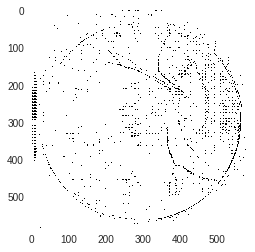

1 39.01944047212601


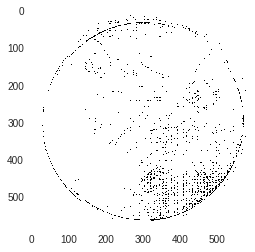

2 14.827944546937943


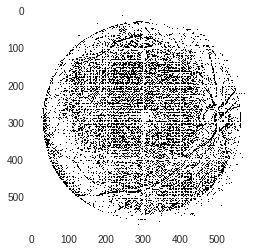

3 10.697543621063232


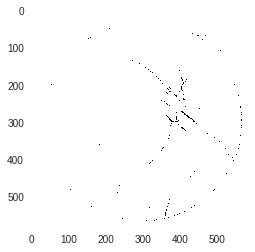

4 10.262331157922745


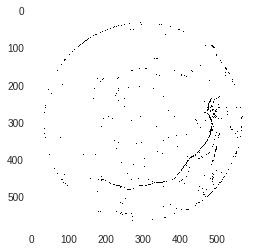

5 9.074061900377274


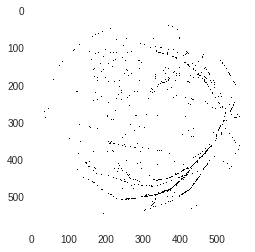

6 9.3054378926754


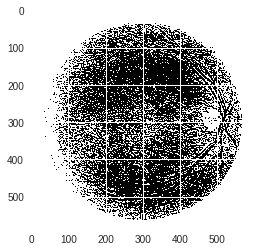

7 7.927226155996323


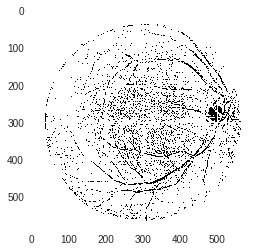

8 8.087698489427567


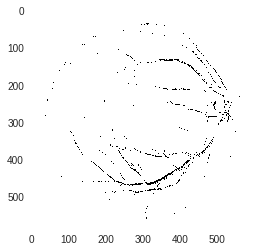

9 7.162126749753952


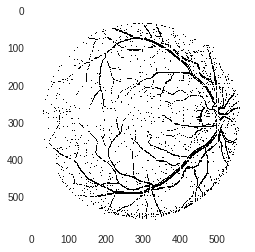

10 6.835392564535141


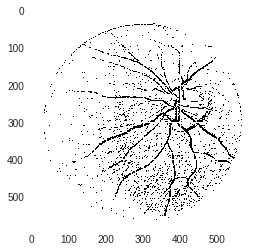

11 6.439613878726959


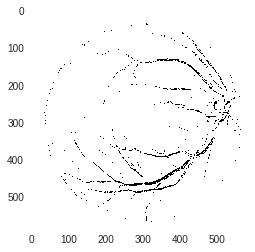

12 6.503226161003113


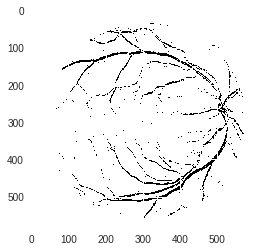

13 6.632546305656433


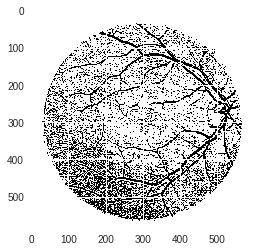

14 5.76863905787468


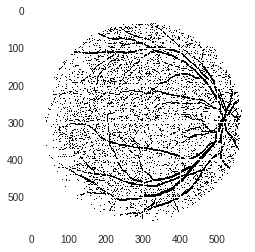

15 5.597066804766655


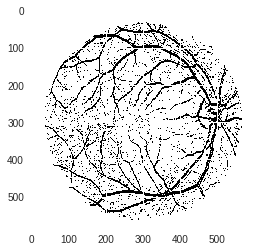

16 5.814818114042282


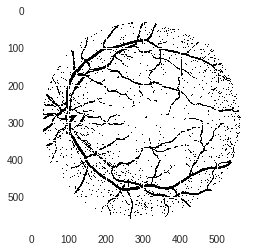

17 5.6247779577970505


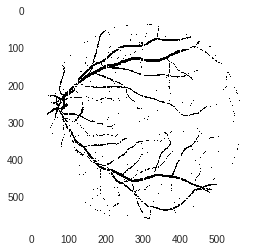

18 5.301962360739708


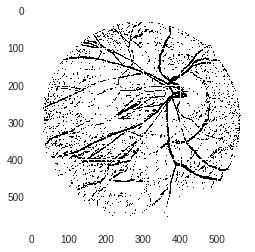

19 5.538731947541237


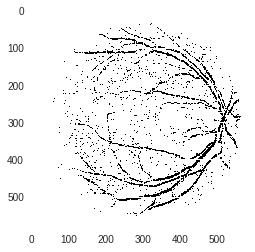

20 5.66948176920414


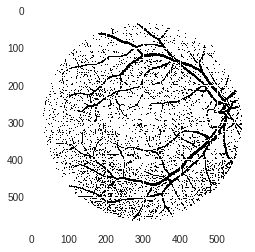

21 5.192472338676453


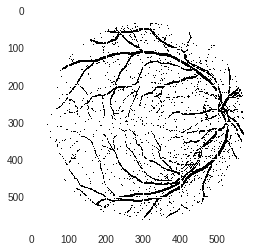

22 5.798574894666672


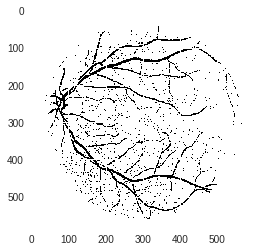

23 5.539139375090599


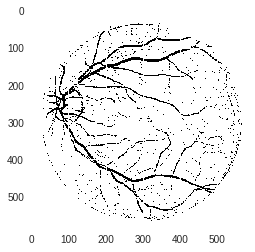

24 5.418179214000702


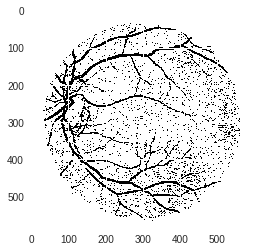

25 5.330122023820877


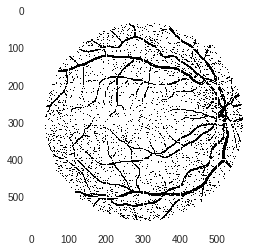

26 5.446991592645645


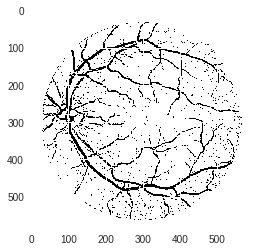

27 5.144236192107201


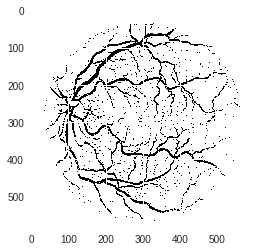

28 5.565139129757881


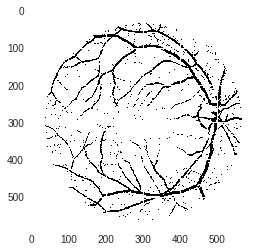

29 5.862420663237572


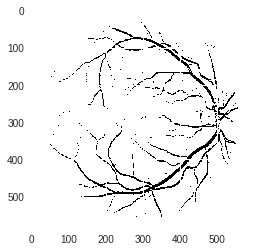

30 5.782767698168755


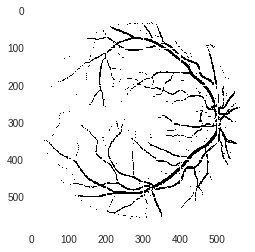

31 4.824471637606621


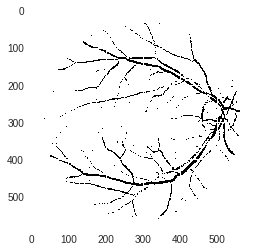

32 4.823284178972244


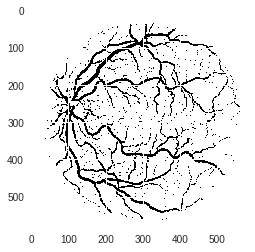

33 4.431532368063927


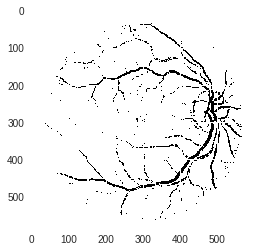

34 4.382938131690025


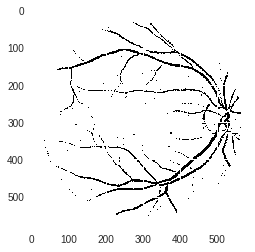

35 4.348761007189751


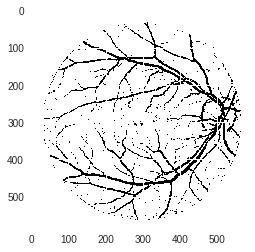

36 4.485585123300552


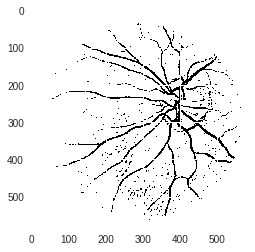

37 4.383583649992943


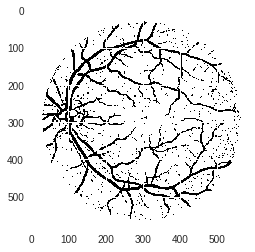

38 4.223168060183525


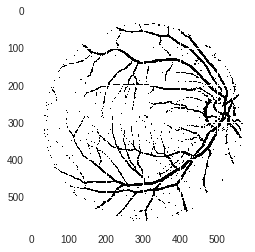

39 4.155882179737091


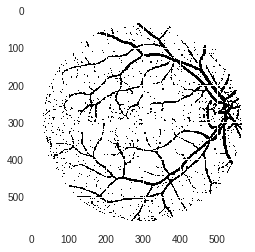

40 4.080209910869598


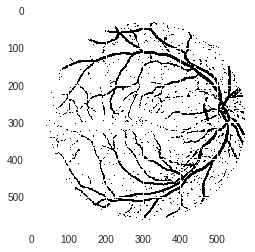

41 4.291803196072578


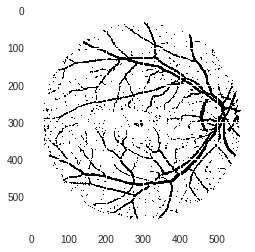

42 4.211912736296654


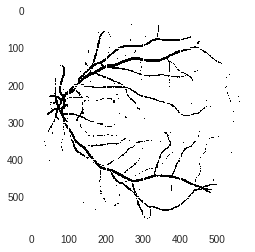

43 4.411123350262642


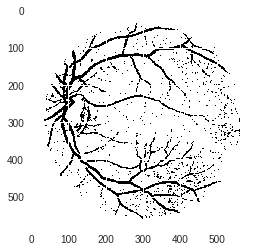

44 4.14788031578064


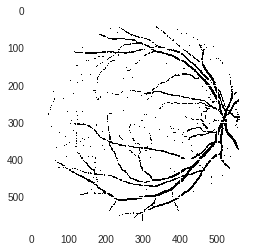

45 4.324732333421707


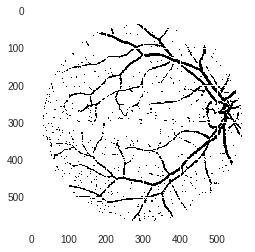

46 4.099732577800751


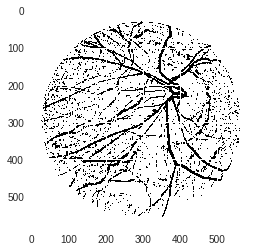

47 3.9699683487415314


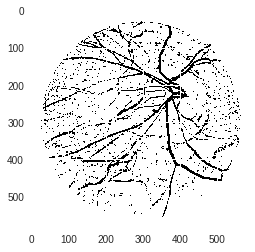

48 4.054583638906479


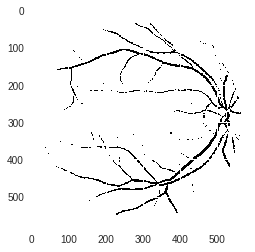

49 4.19951231777668


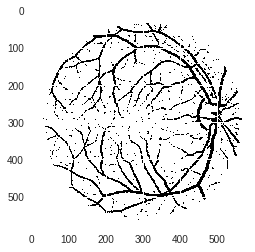

50 4.075088664889336


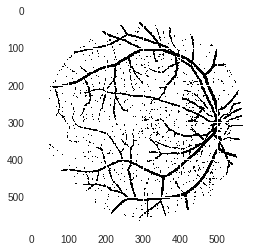

51 3.873177632689476


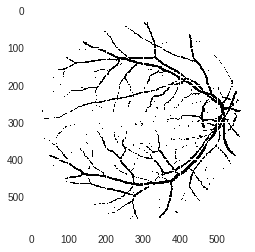

52 3.906880348920822


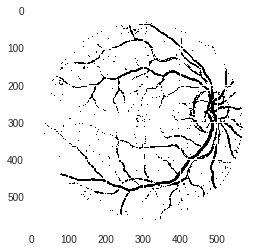

53 4.145255357027054


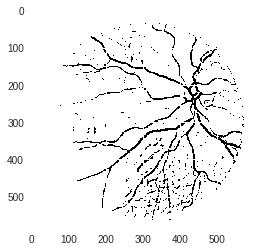

54 3.9097713083028793


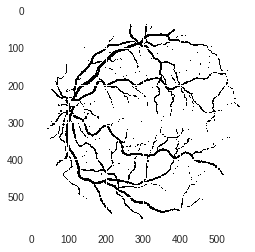

55 4.1190346628427505


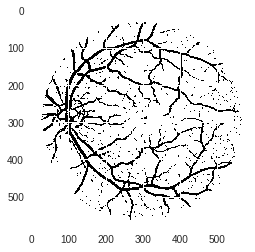

56 3.857662096619606


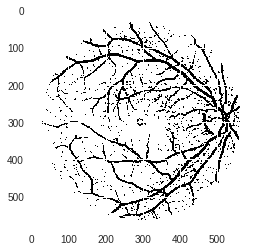

57 3.8935643136501312


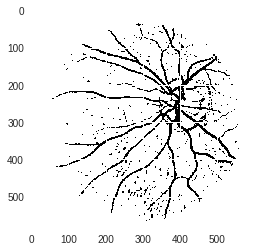

58 4.034123748540878


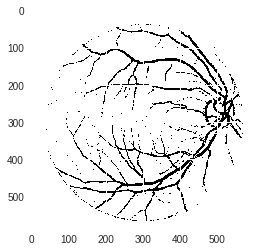

59 4.4122554659843445


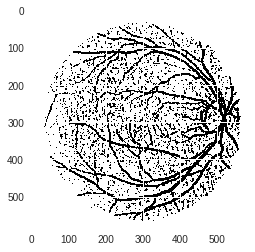

60 4.313306480646133


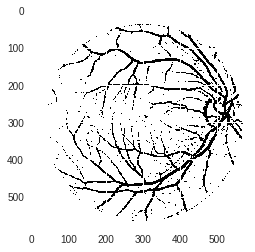

61 4.317408695816994


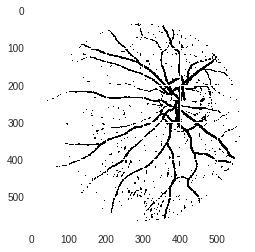

62 4.1007063537836075


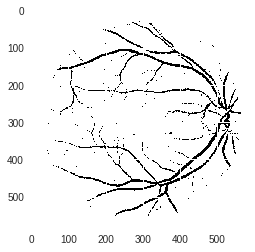

63 4.180264592170715


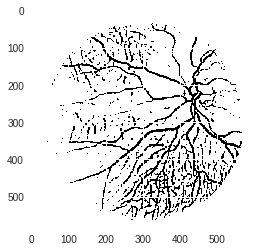

64 4.136742830276489


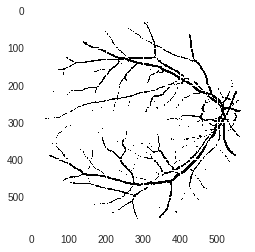

65 3.946406275033951


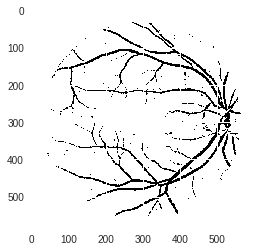

66 4.330100283026695


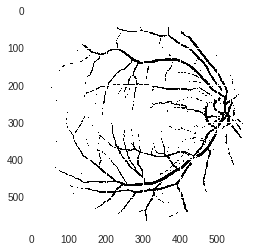

67 3.867571249604225


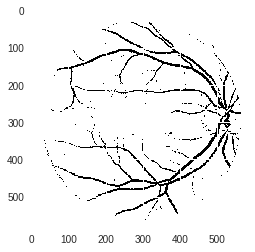

68 3.825551152229309


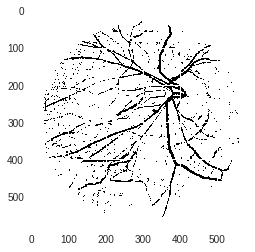

69 3.725743383169174


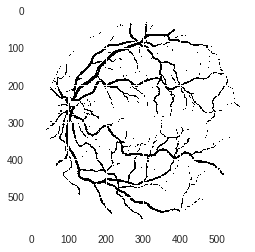

70 3.653796523809433


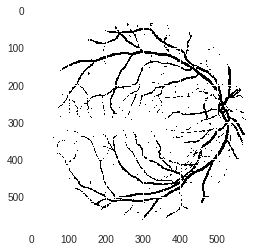

71 3.69023235142231


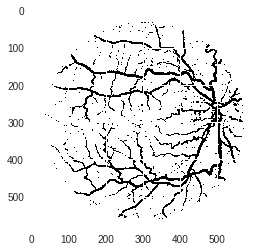

72 4.074367314577103


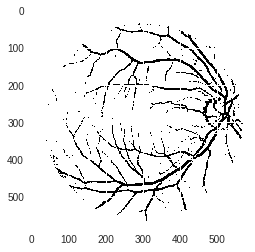

73 3.905454471707344


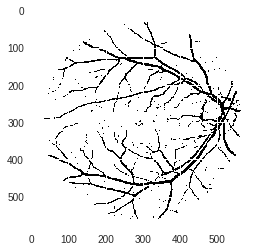

74 3.702932134270668


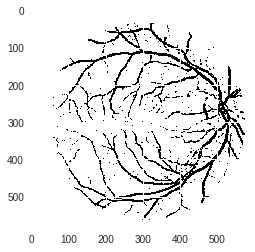

75 3.573020786046982


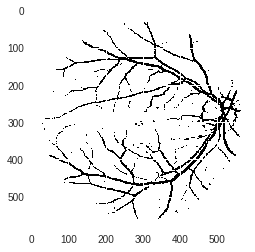

76 3.6291127800941467


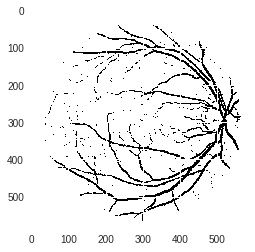

77 3.5787585079669952


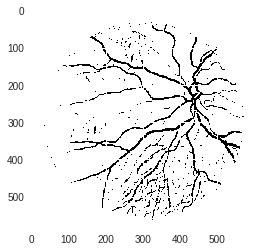

78 3.62817645072937


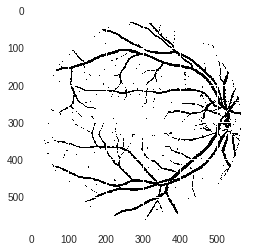

79 3.555738925933838


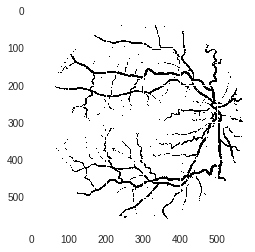

80 4.24861079454422


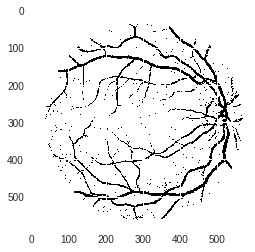

81 4.303437560796738


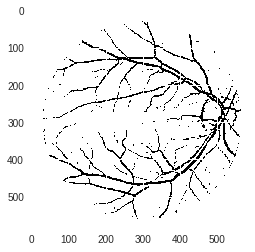

82 3.9730428606271744


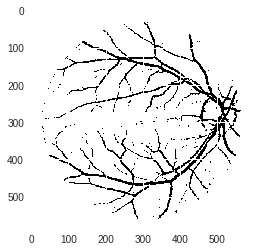

83 3.7646271139383316


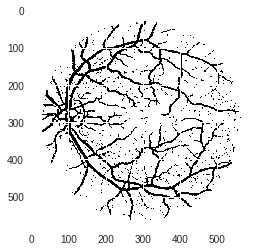

84 3.6695445775985718


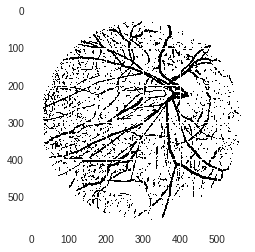

85 3.5980850756168365


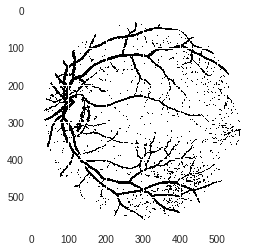

86 3.67173233628273


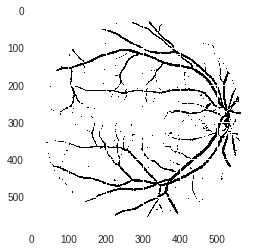

87 3.6446030288934708


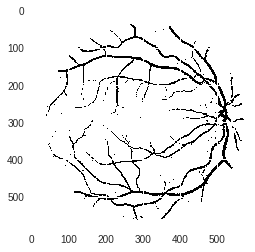

88 3.803022190928459


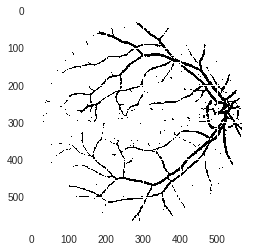

89 3.616764113306999


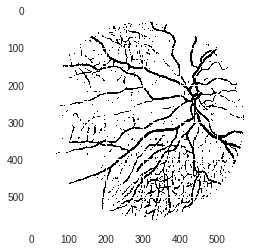

90 3.496738389134407


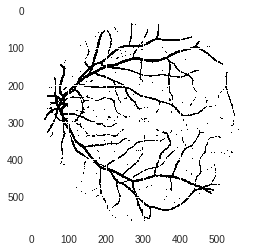

91 3.501277133822441


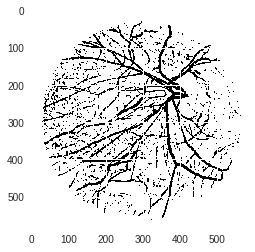

92 3.411934182047844


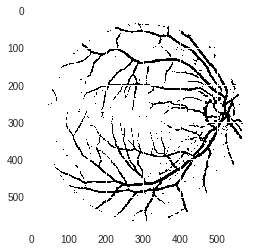

93 3.5469648092985153


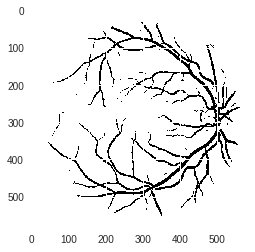

94 3.6261041164398193


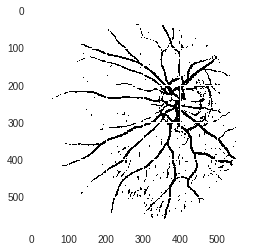

95 3.674964040517807


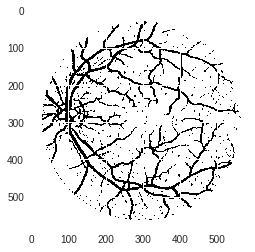

96 3.5943238139152527


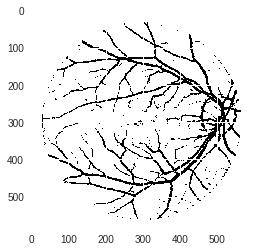

97 3.494865581393242


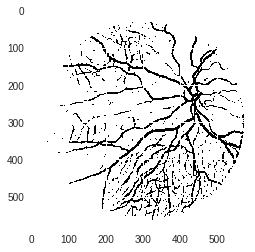

98 3.552263043820858


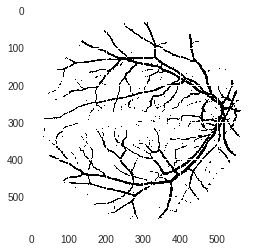

99 3.4288903921842575


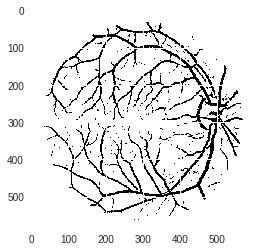

In [14]:
losses = []
unet.train()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# loss seems to converge after 1o epochs to 1.53
for epoch in range(100):
    epoch_loss = 0
    #scheduler.step()
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        #print(inputs.size())
        #print(labels.size())
        inputs = inputs.to(device)
        labels = labels.to(device)
        #imshow(labels)
        optimizer.zero_grad()
        
        output = unet(inputs)
        loss = EngergyFunction(output,labels)
        epoch_loss += loss.item() # logging
        
        loss.backward()
        optimizer.step()

    losses.append(epoch_loss)
    print(epoch,epoch_loss)
    pred = output.data.max(1)[1].cpu().numpy()
    pred = np.resize(pred,(584,584))
    plt.imshow(pred)
    plt.show()

## Parameter Tuning
The average accuracy of a complete black image is 0.816459467066992.

| Optimizer | Loss | OtherSettings | Epochs | Accuracy | Loss after last Epoch | Comments
|:--- | :--- | --- | --- | --- |
| Adam: lr = 0.0001, weight_decay=0.0005 | weight \[1, 3\] | x | 40 | 0.89 | 5.5 | most parts of the veins clear visible with speckles around
| Adam: lr = 0.001, weight_decay=0.0005 | weight \[1, 3\] | x | 40 | 0.91 | 5.9 | most parts of the veins clear visible with speckles around
| SGD: lr = 0.001,weight_decay=0.0005,momentum=0.99 | weight \[1, 3\] | x | 40 | 0.816 | 8.95 | part of veins visible with lot of speckles around
| SGD: lr = 0.001,weight_decay=0.0005,momentum=0.99 | weight \[1, 3\] | StepLr: step_size=30, gamma=0.1  | 40 | 0.812 | 8.71 | part of veins visible with lot of speckles around
| SGD: lr=0.01,weight_decay=0.0005,momentum=0.99 | weight \[1, 3\] | x | 40 | 0.89 | 8.05 | part of veins visible with lot of speckles around


## Plot Epoch-Loss

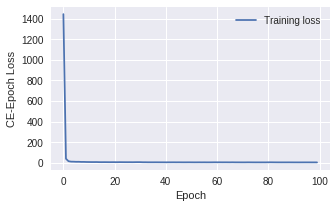

In [15]:
plt.figure(figsize=(5,3))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('CE-Epoch Loss')
plt.legend(['Training loss'])

## Evaluation of the Network

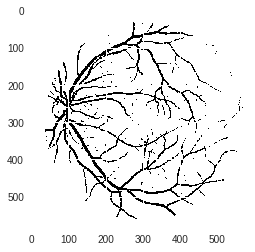

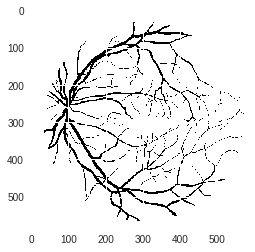

Accuracy = 0.9635602364421092
Dice coefficient = 0.786951006274214


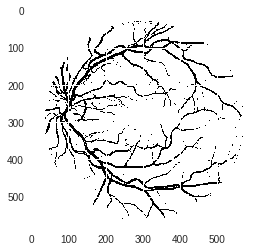

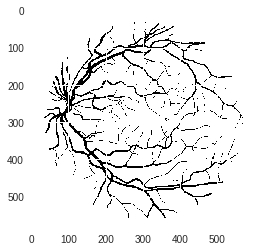

Accuracy = 0.9628125586413961
Dice coefficient = 0.7951083181208705


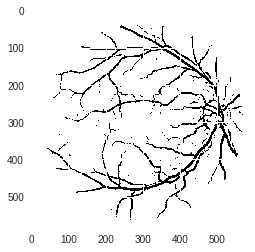

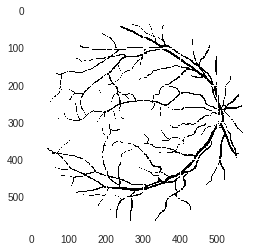

Accuracy = 0.9655511118408707
Dice coefficient = 0.7723811922428657


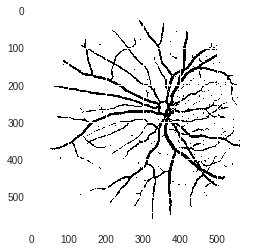

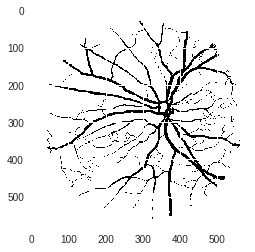

Accuracy = 0.9652109917432914
Dice coefficient = 0.8071829040383521


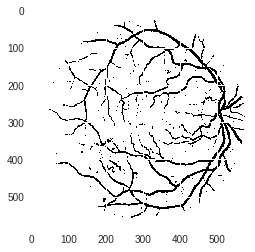

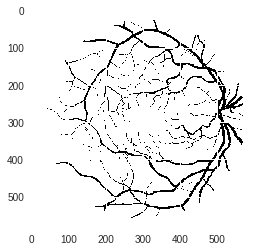

Accuracy = 0.9627891020829424
Dice coefficient = 0.7809970836425132


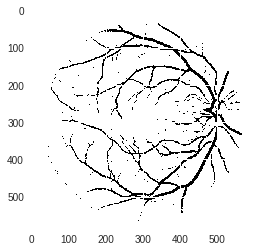

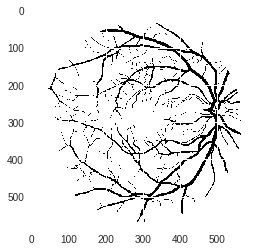

Accuracy = 0.9601854240945769
Dice coefficient = 0.7647884152361816


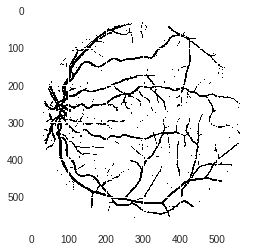

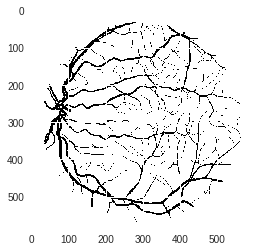

Accuracy = 0.9595608932257459
Dice coefficient = 0.7735526877483335


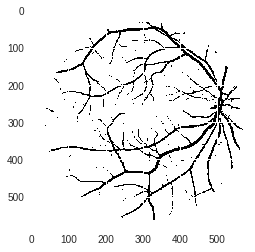

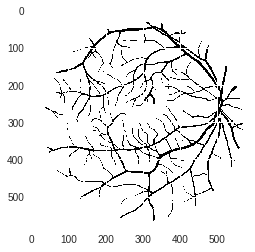

Accuracy = 0.9660495637080128
Dice coefficient = 0.7988814201101211


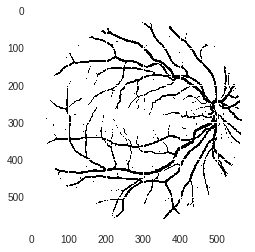

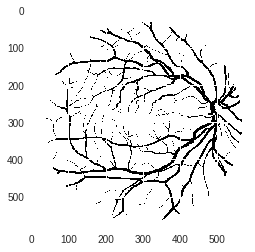

Accuracy = 0.9669262525802215
Dice coefficient = 0.832202784719743


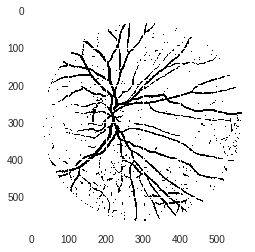

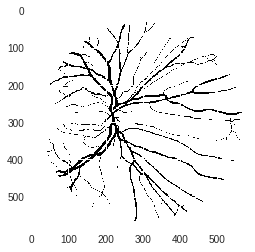

Accuracy = 0.9550777584912742
Dice coefficient = 0.7312341022717306


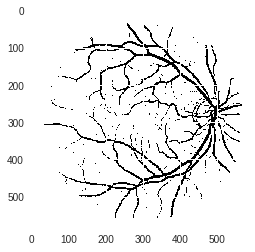

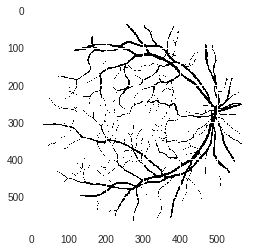

Accuracy = 0.9628301510602364
Dice coefficient = 0.7755925722681489


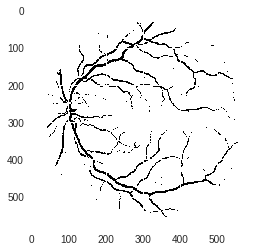

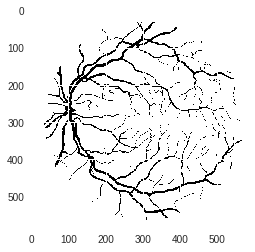

Accuracy = 0.965568704259711
Dice coefficient = 0.7465302510306719


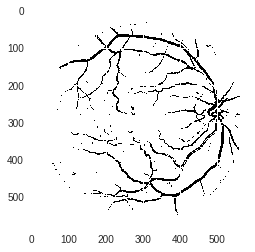

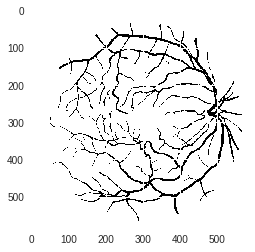

Accuracy = 0.9610239960592982
Dice coefficient = 0.7357729233337972


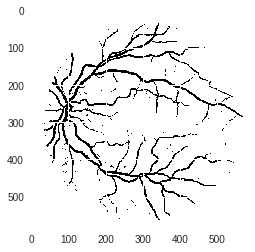

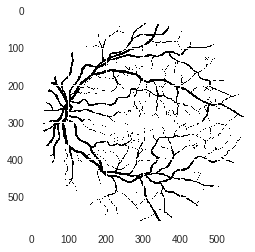

Accuracy = 0.9655335194220304
Dice coefficient = 0.7960582244660733


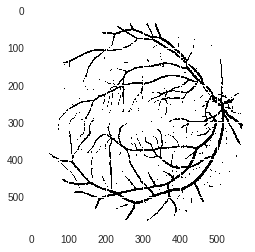

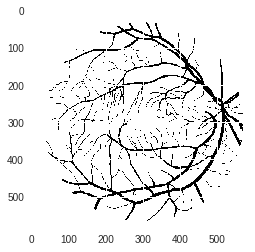

Accuracy = 0.9605636610996434
Dice coefficient = 0.7864130089563616


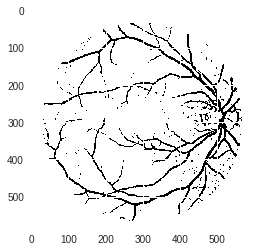

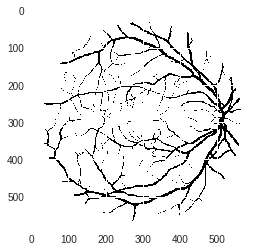

Accuracy = 0.9596400591105273
Dice coefficient = 0.7665960152607036


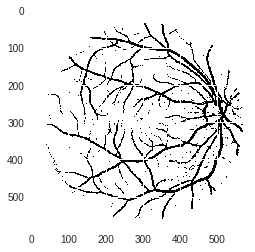

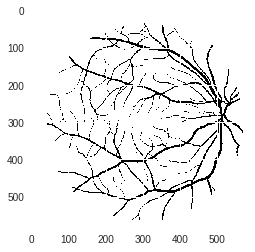

Accuracy = 0.960724924939013
Dice coefficient = 0.7888789068041042


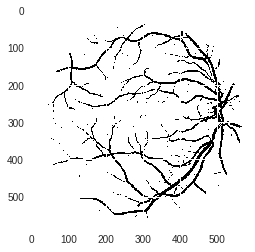

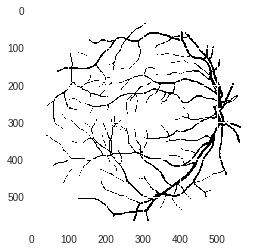

Accuracy = 0.9636716550947645
Dice coefficient = 0.7702832987244141


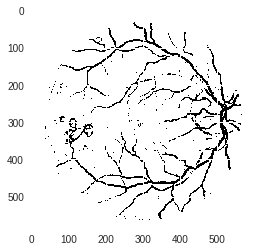

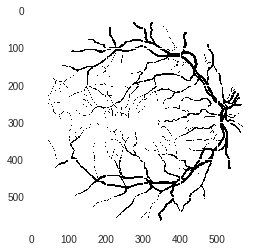

Accuracy = 0.9571741884030776
Dice coefficient = 0.7279263840250354


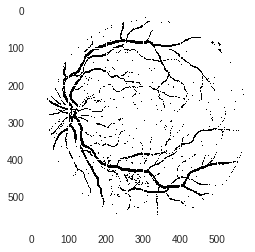

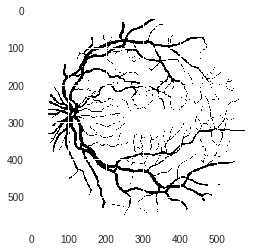

Accuracy = 0.9513129808594483
Dice coefficient = 0.7114331890933736
---------------------------------------------------
Average accuracy = 0.9617883866579093
Average dice = 0.7724382344183806


In [17]:
acc_list = []
dice_list = []
unet.eval()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i, data in enumerate(test_loader, 0):
    # get the inputs
    inputs, labels = data
    labels = labels/255
    inputs = inputs.to(device)
    #labels = labels.to(device)
        
    output = unet(inputs)
    pred = output.data.max(1)[1].cpu().numpy()
    pred = np.resize(pred,(584,584))
    
    pred_map = np.logical_xor(pred,labels)
    pred_map = pred_map.type(torch.DoubleTensor)
    accuracy = 1 - (torch.sum(pred_map)/(584*584))
    acc_list.append(accuracy)
    
    TP = np.multiply(pred,labels).sum()
    TP = TP.type(torch.DoubleTensor)
    dice = 2*TP/(pred.sum()+labels.sum())
    dice_list.append(dice)
    
    plt.imshow(pred)
    plt.show()

    npimg = labels.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    npimg = np.reshape(npimg, (584, 584))
    plt.imshow(npimg)
    plt.show()
    
    print('Accuracy =',accuracy.item())
    print('Dice coefficient =',dice.item())

print('---------------------------------------------------')
avg_acc = sum(acc_list)/len(acc_list)
print('Average accuracy =',avg_acc.item())
avg_dice = sum(dice_list)/len(dice_list)
print('Average dice =',avg_dice.item())

## References
[1] U-Net: Convolutional Networks for Biomedical Image Segmentation